# Quick Start: Using the SAR Recommender System

This notebook demonstrates how to use our custom SAR implementation for generating recommendations.

In [24]:
import pandas as pd
import numpy as np
import sys
import os
import warnings
import itertools
warnings.filterwarnings('ignore')

# Add the src directory to Python path
sys.path.append(os.path.join(os.getcwd(), '..'))

from src.models.sar import SARModel
from src.evaluation.metrics import precision_at_k, recall_at_k, ndcg_at_k

## 1. Load Your Data

Load your interaction data. The data should have these columns:
- UserId: User identifier
- ItemId: Item identifier
- Rating: Interaction strength (e.g., rating, purchase amount)
- Timestamp: Time of interaction

In [25]:
# Load your data
data = pd.read_csv('../data/synthetic_interactions.csv')

# Ensure column names match what the model expects
data = data.rename(columns={
    'user_id': 'UserId',
    'product_id': 'ItemId',
    'interaction_revenue': 'Rating',
    'interaction_timestamp': 'Timestamp'
})

# Convert timestamp to unix timestamp if it's not already
data['Timestamp'] = pd.to_datetime(data['Timestamp']).astype('int64') // 10**9

print("Data shape:", data.shape)
data.head()

Data shape: (100000, 4)


,UserId,Timestamp,Rating,ItemId
0,39309124,1627783200,0.0,20075
1,13243611,1627790400,0.1,29046
2,32143353,1627790400,0.0,12475
3,8744795,1627794000,0.0,22499
4,9571056,1627797600,10.0,23072


## 2. Split Data into Train and Test Sets

We'll use time-based splitting to evaluate our model properly.

In [26]:
# Sort by timestamp
data = data.sort_values('Timestamp')

# Use last 20% of data as test set
split_idx = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 80000
Test set size: 20000


## 3. Train the SAR Model

Initialize and train the SAR model with your preferred parameters.

In [27]:
# Initialize the model
model = SARModel(
    similarity_type='lift', 
    time_decay_coefficient=1, 
    timedecay_formula=True  
)

# Train the model
model.fit(train_data)

## 4. Generate Recommendations

Get recommendations for users in the test set.

In [28]:
# Get unique users from test set that also exist in training set
train_users = set(train_data['UserId'].unique())
test_users = set(test_data['UserId'].unique())
common_users = list(train_users.intersection(test_users))

print(f"Users in training set: {len(train_users)}")
print(f"Users in test set: {len(test_users)}")
print(f"Users in both sets: {len(common_users)}")

# Generate recommendations only for users that exist in both sets
recommendations = model.recommend_items(
    user_ids=common_users,
    n_items=8,
    exclude_seen=True
)

print("Generated recommendations shape:", recommendations.shape)
recommendations.head(10)

Users in training set: 2476
Users in test set: 1909
Users in both sets: 1821
Generated recommendations shape: (14568, 3)


,UserId,ItemId,Score
0,18710530,15491,1.000000e+00
1,18710530,18827,2.939813e-06
2,18710530,17408,8.364924e-07
3,18710530,11062,5.943974e-14
4,18710530,15228,1.157877e-15
5,18710530,16254,8.609717e-24
6,18710530,22438,2.085445e-30
7,18710530,11961,0.000000e+00
8,17235973,12374,1.000000e+00
9,17235973,23111,1.000000e+00


## 5. Evaluate the Model

Calculate various metrics to evaluate the model's performance.

In [29]:
# Calculate metrics at k=10
k = 8

precision = precision_at_k(test_data, recommendations, k)
recall = recall_at_k(test_data, recommendations, k)
ndcg = ndcg_at_k(test_data, recommendations, k)

print(f"Precision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")
print(f"NDCG@{k}: {ndcg:.4f}")

Precision@8: 0.0026
Recall@8: 0.0183
NDCG@8: 0.0792


## 6. Comparison with Popularity Baseline


Comparison of SAR vs Popularity Baseline:
    Metric        SAR   Popularity
-----------------------------------
Precision@8:     0.0026       0.0018
Recall@8:       0.0183       0.0142
NDCG@8:         0.0792       0.0530


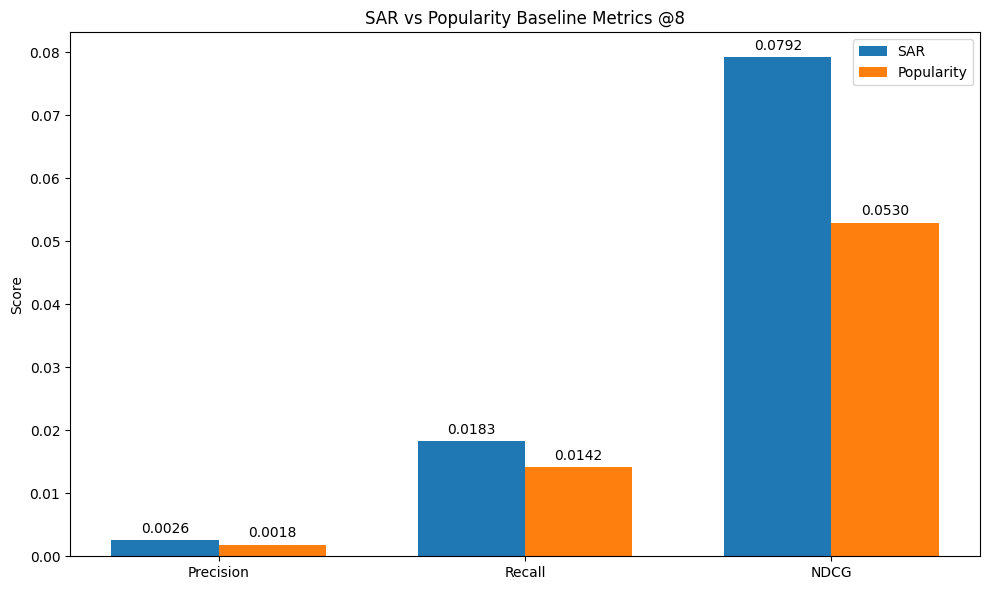

In [30]:
# Implement popularity baseline
def generate_popularity_recs(train_data, test_users, k=8):
    """Generate popularity-based recommendations with proper filtering and scoring"""
    item_counts = train_data['ItemId'].value_counts().to_frame().reset_index()
    item_counts.columns = ['ItemId', 'Count']
    
    # Create all possible user-item pairs for test users
    user_item_list = list(itertools.product(test_users, item_counts['ItemId']))
    users_items = pd.DataFrame(user_item_list, columns=['UserId', 'ItemId'])
    
    # Remove items the users have already interacted with
    users_items_remove_seen = users_items.merge(
        train_data[['UserId', 'ItemId']], 
        on=['UserId', 'ItemId'], 
        how='left', 
        indicator=True
    ).query('_merge == "left_only"').drop('_merge', axis=1)
    
    # Generate recommendations
    baseline_recommendations = pd.merge(item_counts, users_items_remove_seen, on=['ItemId'])
    baseline_recommendations = baseline_recommendations.sort_values(['UserId', 'Count'], ascending=[True, False])
    baseline_recommendations = baseline_recommendations.groupby('UserId').head(k)
    
    # Format to match our SAR recommendations format
    baseline_recommendations = baseline_recommendations.rename(columns={'Count': 'Score'})
    return baseline_recommendations[['UserId', 'ItemId', 'Score']]

# Generate popularity baseline recommendations
pop_recommendations = generate_popularity_recs(train_data, test_users, k=k)

# Calculate metrics for both models
print("\nComparison of SAR vs Popularity Baseline:")
print(f"{'Metric':>10} {'SAR':>10} {'Popularity':>12}")
print("-" * 35)

# SAR metrics (we already have these)
sar_precision = precision
sar_recall = recall
sar_ndcg = ndcg

# Popularity baseline metrics
pop_precision = precision_at_k(test_data, pop_recommendations, k)
pop_recall = recall_at_k(test_data, pop_recommendations, k)
pop_ndcg = ndcg_at_k(test_data, pop_recommendations, k)

# Print comparison
print(f"Precision@{k}: {sar_precision:>10.4f} {pop_precision:>12.4f}")
print(f"Recall@{k}:   {sar_recall:>10.4f} {pop_recall:>12.4f}")
print(f"NDCG@{k}:     {sar_ndcg:>10.4f} {pop_ndcg:>12.4f}")

# Visualize comparison
import matplotlib.pyplot as plt

metrics = ['Precision', 'Recall', 'NDCG']
sar_scores = [sar_precision, sar_recall, sar_ndcg]
pop_scores = [pop_precision, pop_recall, pop_ndcg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, sar_scores, width, label='SAR')
rects2 = ax.bar(x + width/2, pop_scores, width, label='Popularity')

ax.set_ylabel('Score')
ax.set_title(f'SAR vs Popularity Baseline Metrics @{k}')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3), 
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()